In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import os
import sys
import traceback

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import pydicom
import cv2
import glob, pylab

import PIL
# from tensorflow.keras.models import Sequential
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.layers import Input,GlobalAveragePooling2D, ZeroPadding2D, Convolution2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, Activation 
# from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.models import Model,load_model
# from tensorflow.keras.applications.imagenet_utils import decode_predictions 
# from tensorflow.keras.applications import MobileNet, VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

# from tensorflow.keras.applications.mobilenet import preprocess_input
# from sklearn.model_selection import GridSearchCV

In [2]:
# prefix = '/opt/ml/'
prefix = './'

input_path = os.path.join(prefix , 'input/data/')
output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

training_path = os.path.join(input_path, 'stage_2_train_images/')
training_labels_path = input_path + 'stage_2_train_labels.csv'

In [3]:
print(training_path)
print(training_labels_path)

./input/data/stage_2_train_images/
./input/data/stage_2_train_labels.csv


In [4]:
def create_model(X_train, y_train):
    classifier = load_model(os.path.join(model_path,'mobilenet_model.h5'))

    # Compiling the MobileNet
    classifier.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # declare the callbacks
    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint(os.path.join(model_path,'model-pneumonia-classification.h5'), verbose=1, save_best_only=True, save_weights_only=True)
    ]
    # Fit gridsearch to training set
    history = classifier.fit(
        X_train,
        y_train,
        batch_size=50, 
        epochs=20, 
        callbacks=callbacks,
        validation_split = 0.2
    )
    return history

In [5]:
# method to prepare training data and labels    
def prepare_data(data,img_width,img_height):
    X_train = []
    y_train = []
    for key in tqdm(data):
        img = load_image(data[key]['image_path'],img_width,img_height)
        label = data[key]['target']
        if label == 1:
            encoded_label = [1,0]
        else:
            encoded_label = [0,1]
        X_train.append(img)
        y_train.append(encoded_label)
    print('training data processed==>'+str(len(X_train)))
    print('validation data processed==>'+str(len(y_train)))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.stack((X_train,) * 3, -1)
    return X_train, y_train

In [6]:
# method to load the image and read .dcm file using pydicom
def load_image(image_path,img_width,img_height):
    #this method helps in reading .dcm file
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    #calling cv2.resize to reduce the dimension of image
    res = cv2.resize(img, (img_width,img_height), interpolation=cv2.INTER_AREA)
    #converting the image array data into float 
    res = res.astype(np.float32)/255
    cv2.destroyAllWindows()
    return res

In [7]:
# draw an image with detected objects
def draw_image_with_boxes(res, boxes_list,factor):
#      print(boxes_list)
     # plot the image
     plt.imshow(res, cmap=plt.cm.bone)
     # get the context for drawing boxes
     ax = plt.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
#           x1, y1, width, height = box
            x1 = box[0]/factor
            y1 = box[1]/factor
            width = box[2]/factor
            height = box[3]/factor
            rect = Rectangle((x1,y1), width, height, ec='k', fc='none')
            ax.add_patch(rect)
     # show the plot
     plt.show()

In [8]:
IMG_ACTUAL_SIZE = 1024
def test_images(data,img_width,img_height):
    for key in tqdm(data):
            res = load_image(data[key]['image_path'],img_width,img_height)
            print('patientId==>',key)
            print('target==>',data[key]["target"])
            draw_image_with_boxes(res,data[key]["bboxes"],(IMG_ACTUAL_SIZE/img_width))
            print('End Iterator-->',key,'--------------------------------------------------')
            

In [9]:
# create a dictionary of metadata info from training labels file
def create_dictionary(data):
    metainfo = {}
    for index, row in tqdm(data.iterrows()): 
        patientid = row['patientId']
        # print(patientid)
        if patientid not in metainfo:
            metainfo[patientid] = {
                'target': row['Target'],
                'bboxes': [],
                'image_path': os.path.join(training_path,patientid + '.dcm')
            }
        if metainfo[patientid]['target'] == 1:
            metainfo[patientid]['bboxes'].append([row['x'],row['y'],row['width'],row['height']])
    return metainfo

In [10]:
def train():
    print('Starting the training.')
    try:
        df_train_labels = pd.read_csv(training_labels_path)
        df_train_labels = df_train_labels.fillna(0) #data imputation replacing NAN values with 0s
        metainfo = create_dictionary(df_train_labels)
        test_images(metainfo,128,128)
        X, y = prepare_data(metainfo,128,128)
        classifier = create_model(X, y)
        print('Training is complete.')
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)
    return classifier

18it [00:00, 6543.38it/s]
  0%|          | 0/14 [00:00<?, ?it/s]

Starting the training.
patientId==> 0004cfab-14fd-4e49-80ba-63a80b6bddd6
target==> 0


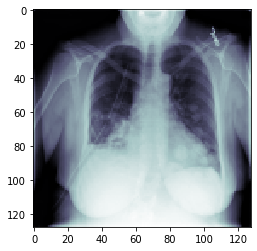

  7%|▋         | 1/14 [00:00<00:04,  2.96it/s]

End Iterator--> 0004cfab-14fd-4e49-80ba-63a80b6bddd6 --------------------------------------------------
patientId==> 00313ee0-9eaa-42f4-b0ab-c148ed3241cd
target==> 0


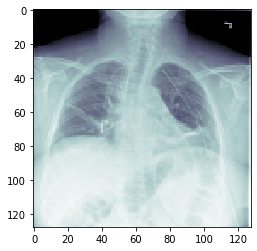

 14%|█▍        | 2/14 [00:00<00:03,  3.08it/s]

End Iterator--> 00313ee0-9eaa-42f4-b0ab-c148ed3241cd --------------------------------------------------
patientId==> 00322d4d-1c29-4943-afc9-b6754be640eb
target==> 0


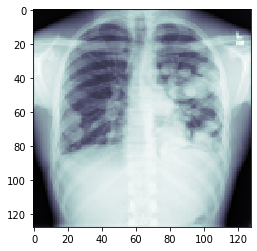

 21%|██▏       | 3/14 [00:00<00:03,  3.15it/s]

End Iterator--> 00322d4d-1c29-4943-afc9-b6754be640eb --------------------------------------------------
patientId==> 003d8fa0-6bf1-40ed-b54c-ac657f8495c5
target==> 0


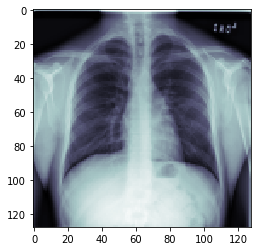

 29%|██▊       | 4/14 [00:01<00:03,  3.15it/s]

End Iterator--> 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 --------------------------------------------------
patientId==> 00436515-870c-4b36-a041-de91049b9ab4
target==> 1


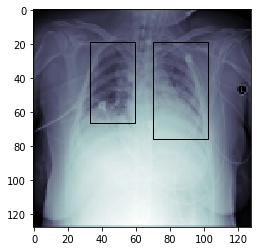

 36%|███▌      | 5/14 [00:01<00:02,  3.16it/s]

End Iterator--> 00436515-870c-4b36-a041-de91049b9ab4 --------------------------------------------------
patientId==> 00569f44-917d-4c86-a842-81832af98c30
target==> 0


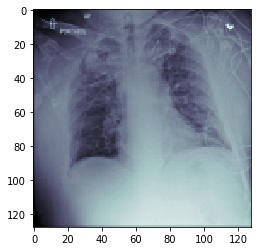

 43%|████▎     | 6/14 [00:01<00:02,  3.13it/s]

End Iterator--> 00569f44-917d-4c86-a842-81832af98c30 --------------------------------------------------
patientId==> 006cec2e-6ce2-4549-bffa-eadfcd1e9970
target==> 0


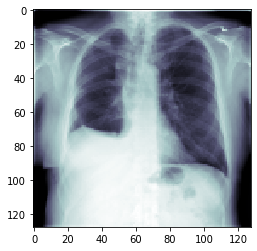

 50%|█████     | 7/14 [00:02<00:02,  3.19it/s]

End Iterator--> 006cec2e-6ce2-4549-bffa-eadfcd1e9970 --------------------------------------------------
patientId==> 00704310-78a8-4b38-8475-49f4573b2dbb
target==> 1


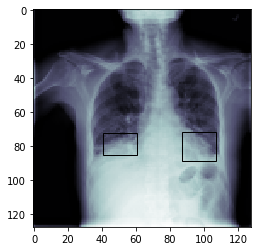

 57%|█████▋    | 8/14 [00:02<00:01,  3.20it/s]

End Iterator--> 00704310-78a8-4b38-8475-49f4573b2dbb --------------------------------------------------
patientId==> 008c19e8-a820-403a-930a-bc74a4053664
target==> 0


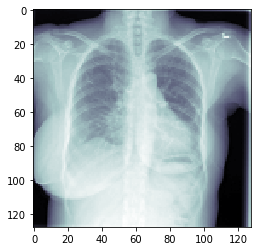

 64%|██████▍   | 9/14 [00:02<00:01,  3.34it/s]

End Iterator--> 008c19e8-a820-403a-930a-bc74a4053664 --------------------------------------------------
patientId==> 009482dc-3db5-48d4-8580-5c89c4f01334
target==> 0


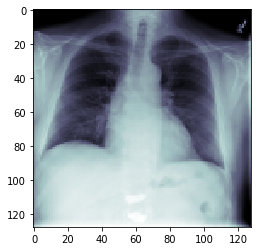

 71%|███████▏  | 10/14 [00:03<00:01,  3.35it/s]

End Iterator--> 009482dc-3db5-48d4-8580-5c89c4f01334 --------------------------------------------------
patientId==> 009eb222-eabc-4150-8121-d5a6d06b8ebf
target==> 0


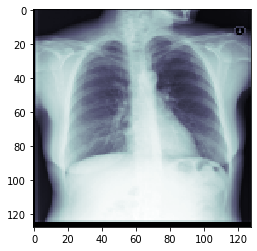

 79%|███████▊  | 11/14 [00:03<00:00,  3.29it/s]

End Iterator--> 009eb222-eabc-4150-8121-d5a6d06b8ebf --------------------------------------------------
patientId==> 00a85be6-6eb0-421d-8acf-ff2dc0007e8a
target==> 0


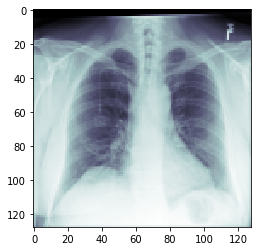

 86%|████████▌ | 12/14 [00:03<00:00,  3.31it/s]

End Iterator--> 00a85be6-6eb0-421d-8acf-ff2dc0007e8a --------------------------------------------------
patientId==> 00aecb01-a116-45a2-956c-08d2fa55433f
target==> 1


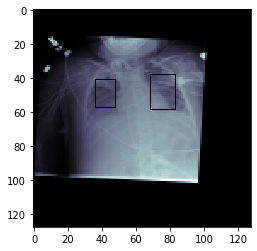

 93%|█████████▎| 13/14 [00:03<00:00,  3.38it/s]

End Iterator--> 00aecb01-a116-45a2-956c-08d2fa55433f --------------------------------------------------
patientId==> 00c0b293-48e7-4e16-ac76-9269ba535a62
target==> 1


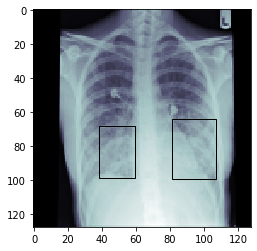

 43%|████▎     | 6/14 [00:00<00:00, 57.70it/s]

End Iterator--> 00c0b293-48e7-4e16-ac76-9269ba535a62 --------------------------------------------------


100%|██████████| 14/14 [00:00<00:00, 52.95it/s]


training data processed==>14
validation data processed==>14
Train on 11 samples, validate on 3 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.51274, saving model to ./model\model-pneumonia-classification.h5
11/11 [==============================] - 9s 824ms/sample - loss: 4.6864e-04 - accuracy: 1.0000 - val_loss: 0.5127 - val_accuracy: 0.6667
Epoch 2/20

Epoch 00002: val_loss improved from 0.51274 to 0.00171, saving model to ./model\model-pneumonia-classification.h5
11/11 [==============================] - 1s 104ms/sample - loss: 1.4207e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.00171
11/11 [==============================] - 1s 81ms/sample - loss: 0.1948 - accuracy: 0.9091 - val_loss: 0.2947 - val_accuracy: 0.6667
Epoch 4/20

Epoch 00004: val_loss improved from 0.00171 to 0.00001, saving model to ./model\model-pneumonia-classification.h5
11/11 [==============================] - 1s 102ms/samp

In [11]:
history = train()

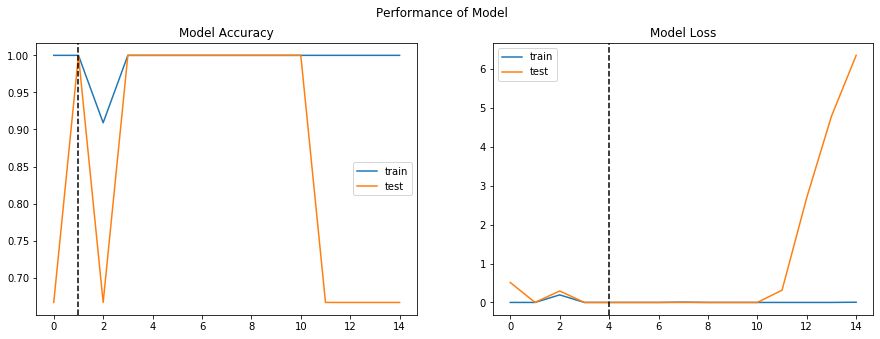

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()